In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import warnings
from cmdstanpy import cmdstan_path, CmdStanModel

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
stan_file = os.path.join('stan', 'binomial_model.stan')
print(stan_file)

stan/binomial_model.stan


In [4]:
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> ntrials; // Numero di prove
  int<lower=0> y; // Successi osservati
  real<lower=0> alpha_prior; // Parametro alpha per il prior Beta
  real<lower=0> beta_prior; // Parametro beta per il prior Beta
}
parameters {
  real<lower=0, upper=1> theta; // Parametro stimato, limitato tra 0 e 1
}
model {
  // Prior
  theta ~ beta(alpha_prior, beta_prior);
  
  // Likelihood
  y ~ binomial(ntrials, theta);
}



In [5]:
model = CmdStanModel(stan_file=stan_file)
print(model)

CmdStanModel: name=binomial_model
	 stan_file=/Users/corradocaudek/_repositories/temp/chapter_4/stan/binomial_model.stan
	 exe_file=/Users/corradocaudek/_repositories/temp/chapter_4/stan/binomial_model
	 compiler_options=stanc_options={}, cpp_options={}


In [6]:
data = {
    "ntrials" : 27,
    "y" : 4,
    "alpha_prior" : 2,
    "beta_prior" : 2
}
print(data)

{'ntrials': 27, 'y': 4, 'alpha_prior': 2, 'beta_prior': 2}


In [7]:
fit = model.sample(
    data=data,
    iter_sampling = 4000,
    iter_warmup = 2000,
    seed = 84735,
    chains = 4
)

09:47:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:47:03 - cmdstanpy - INFO - CmdStan done processing.


In [8]:
print(fit.diagnose())

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpsnr_fyfd/binomial_model4rc8etwd/binomial_model-20240616094703_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpsnr_fyfd/binomial_model4rc8etwd/binomial_model-20240616094703_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpsnr_fyfd/binomial_model4rc8etwd/binomial_model-20240616094703_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpsnr_fyfd/binomial_model4rc8etwd/binomial_model-20240616094703_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [9]:
type(fit)

cmdstanpy.stanfit.mcmc.CmdStanMCMC

In [10]:
az.summary(fit, var_names=("theta"), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.194,0.069,0.067,0.317,0.001,0.001,5511.0,6445.0,1.0


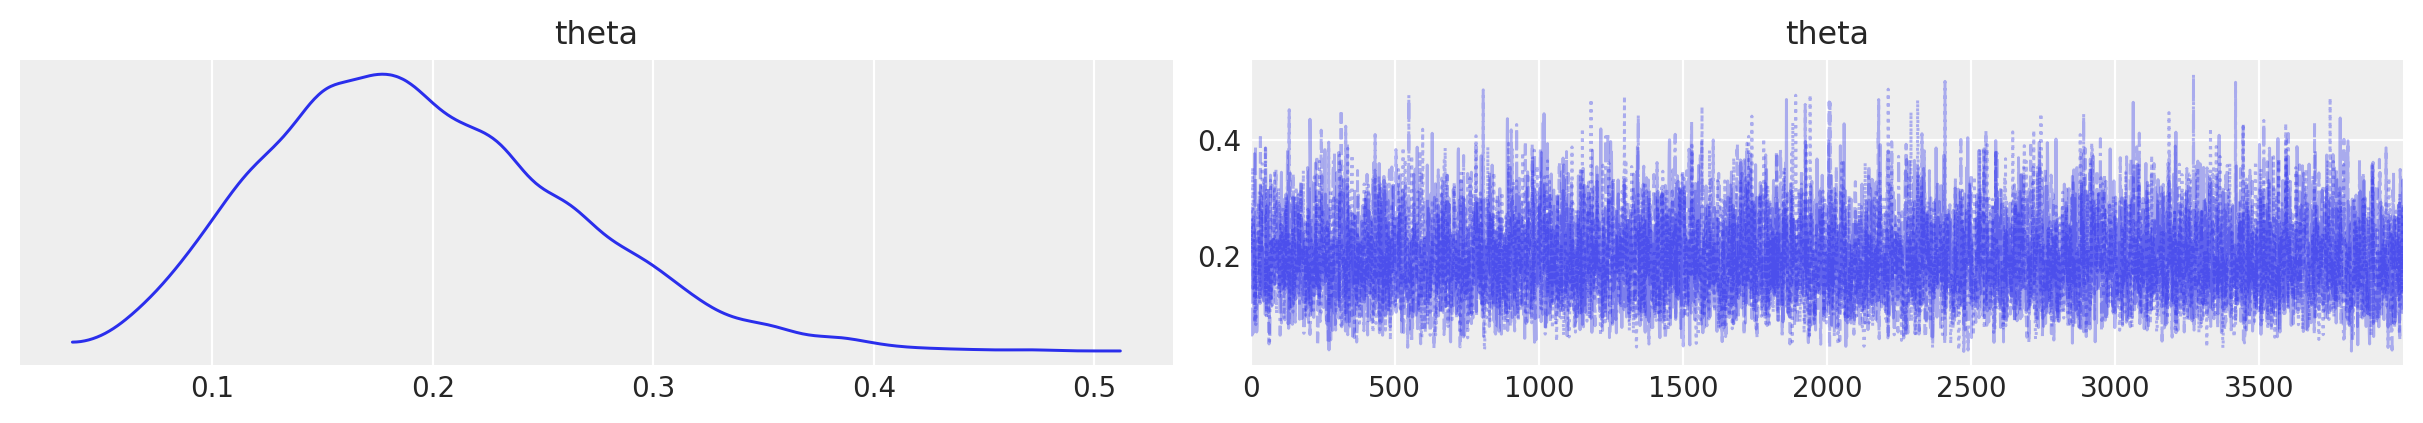

In [11]:
_ = az.plot_trace(fit, var_names=("theta"), combined=True)

In [12]:
post = az.extract(fit)
post

<xarray.Dataset> Size: 512kB
Dimensions:  (sample: 16000)
Coordinates:
  * sample   (sample) object 128kB MultiIndex
  * chain    (sample) int64 128kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 128kB 0 1 2 3 4 5 ... 3994 3995 3996 3997 3998 3999
Data variables:
    theta    (sample) float64 128kB 0.07108 0.1093 0.07958 ... 0.2238 0.2448
Attributes:
    created_at:                 2024-06-16T07:47:03.709664+00:00
    arviz_version:              0.18.0
    inference_library:          cmdstanpy
    inference_library_version:  1.2.3

In [13]:
post["theta"].shape

(16000,)

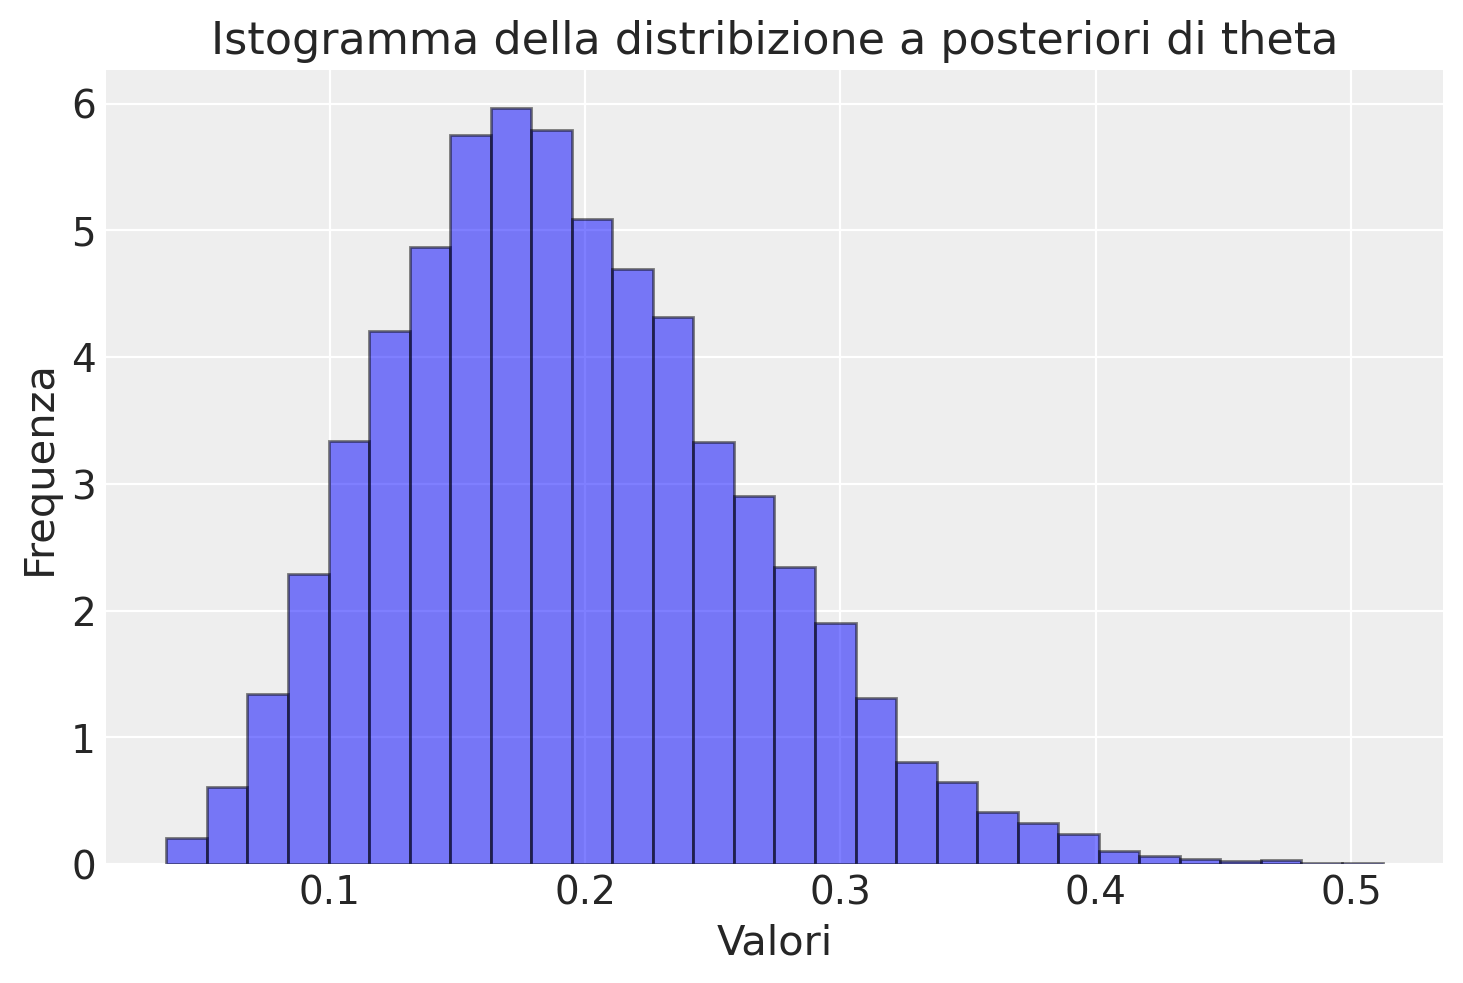

In [14]:
plt.hist(post["theta"], bins=30, alpha=0.5, color='b', edgecolor='black', density=True)

# Aggiunta di titolo e etichette agli assi
plt.title('Istogramma della distribizione a posteriori di theta')
plt.xlabel('Valori')
plt.ylabel('Frequenza')

plt.show()

In [15]:
np.mean(post["theta"].values)

0.19373342785625003

In [16]:
alpha_post = data["alpha_prior"] + data["y"]
beta_post = data["beta_prior"] + data["ntrials"] - data["y"]

alpha_post / (alpha_post + beta_post)

0.1935483870967742

In [17]:
alpha_prior = data["alpha_prior"]
beta_prior = data["beta_prior"]

n = data["ntrials"]
y = data["y"]

Text(0, 0.5, 'Densità')

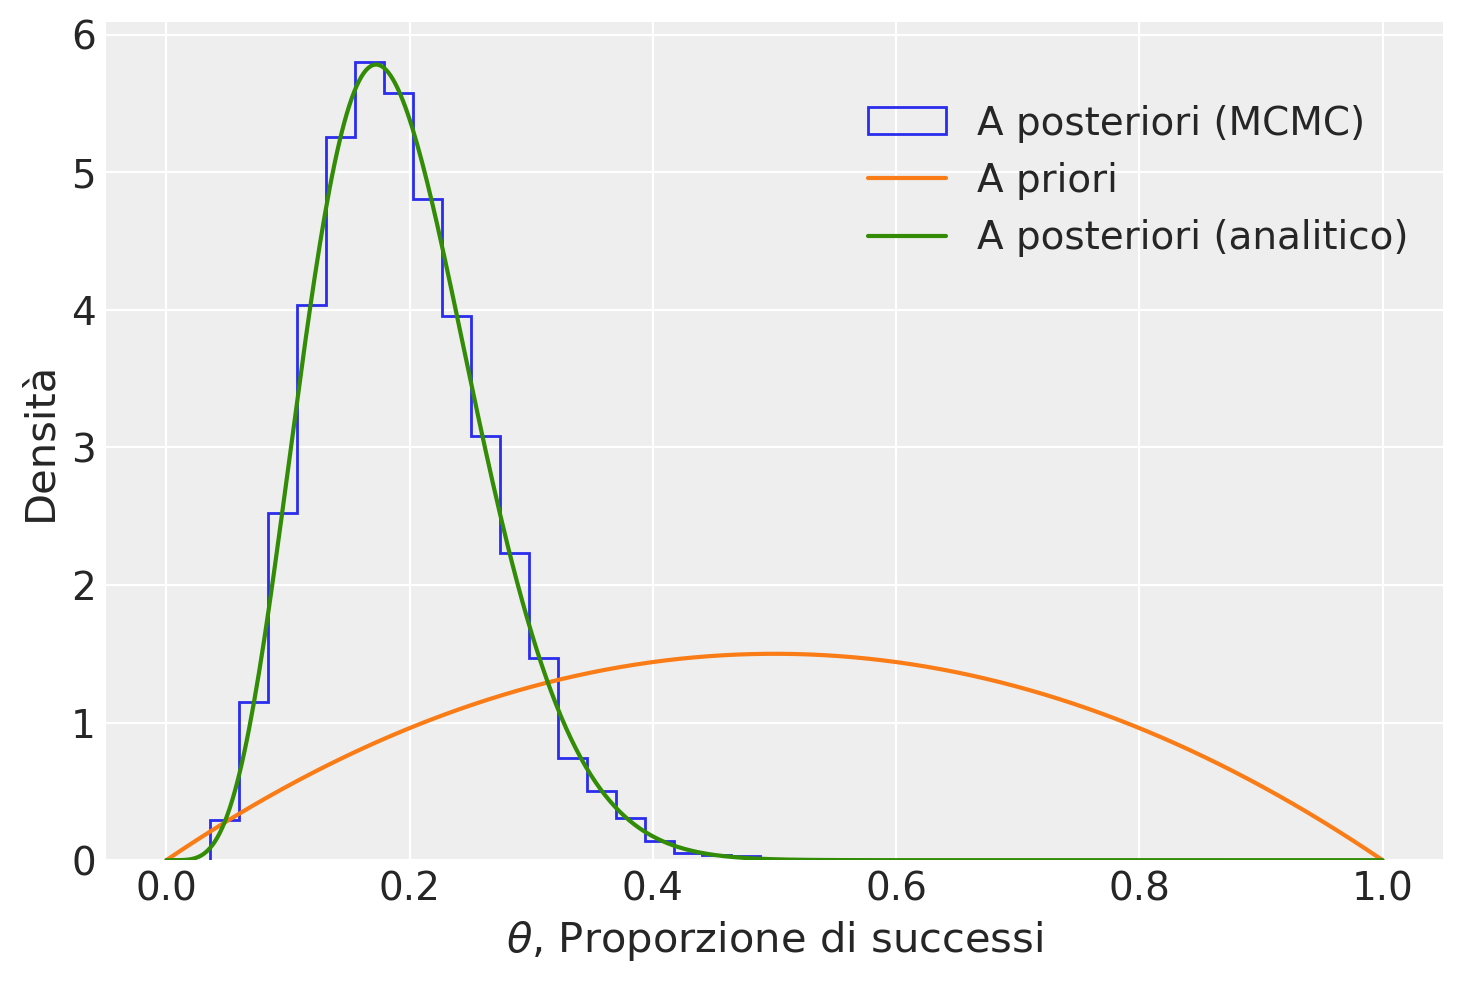

In [18]:
p_post = post["theta"]

# Posterior: Beta(alpha + y, beta + n - y)
alpha_post = alpha_prior + y
beta_post = beta_prior + n - y

plt.hist(
    p_post,
    bins=20,
    histtype="step",
    density=True,
    label="A posteriori (MCMC)",
    color="C0",
)

# Plot the analytic prior and posterior beta distributions
x = np.linspace(0, 1, 500)
plt.plot(
    x, stats.beta.pdf(x, alpha_prior, beta_prior), label="A priori", color="C1"
)
plt.plot(
    x,
    stats.beta.pdf(x, alpha_post, beta_post),
    label="A posteriori (analitico)",
    color="C2",
)

# Update the graph labels
plt.legend(title=" ", loc="best")
plt.xlabel("$\\theta$, Proporzione di successi")
plt.ylabel("Densità")

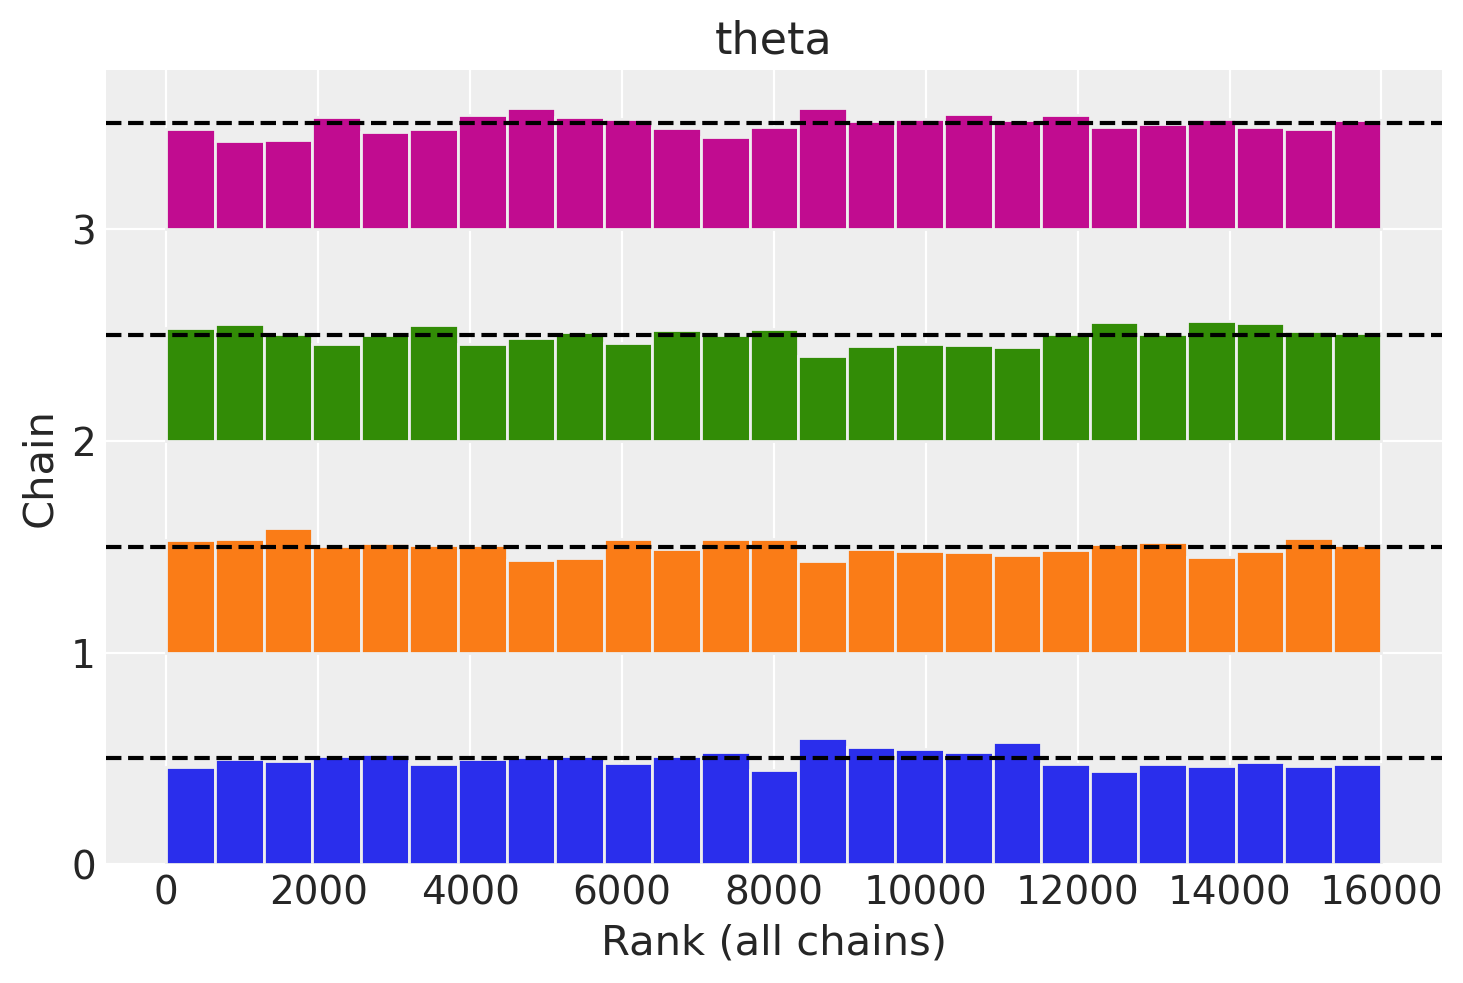

In [19]:
_ = az.plot_rank(fit, var_names="theta", kind="bars")

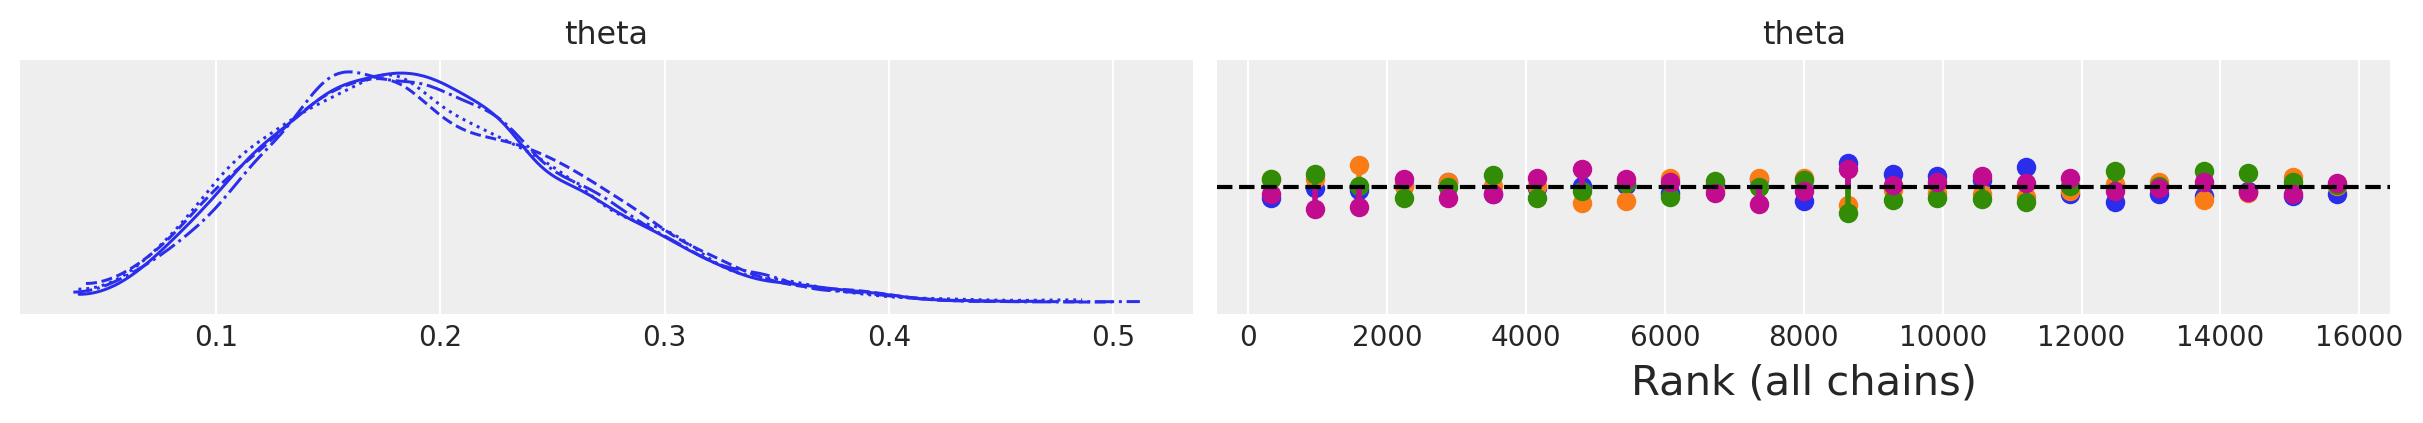

In [20]:
_ = az.plot_trace(fit, var_names=("theta"), kind="rank_vlines")

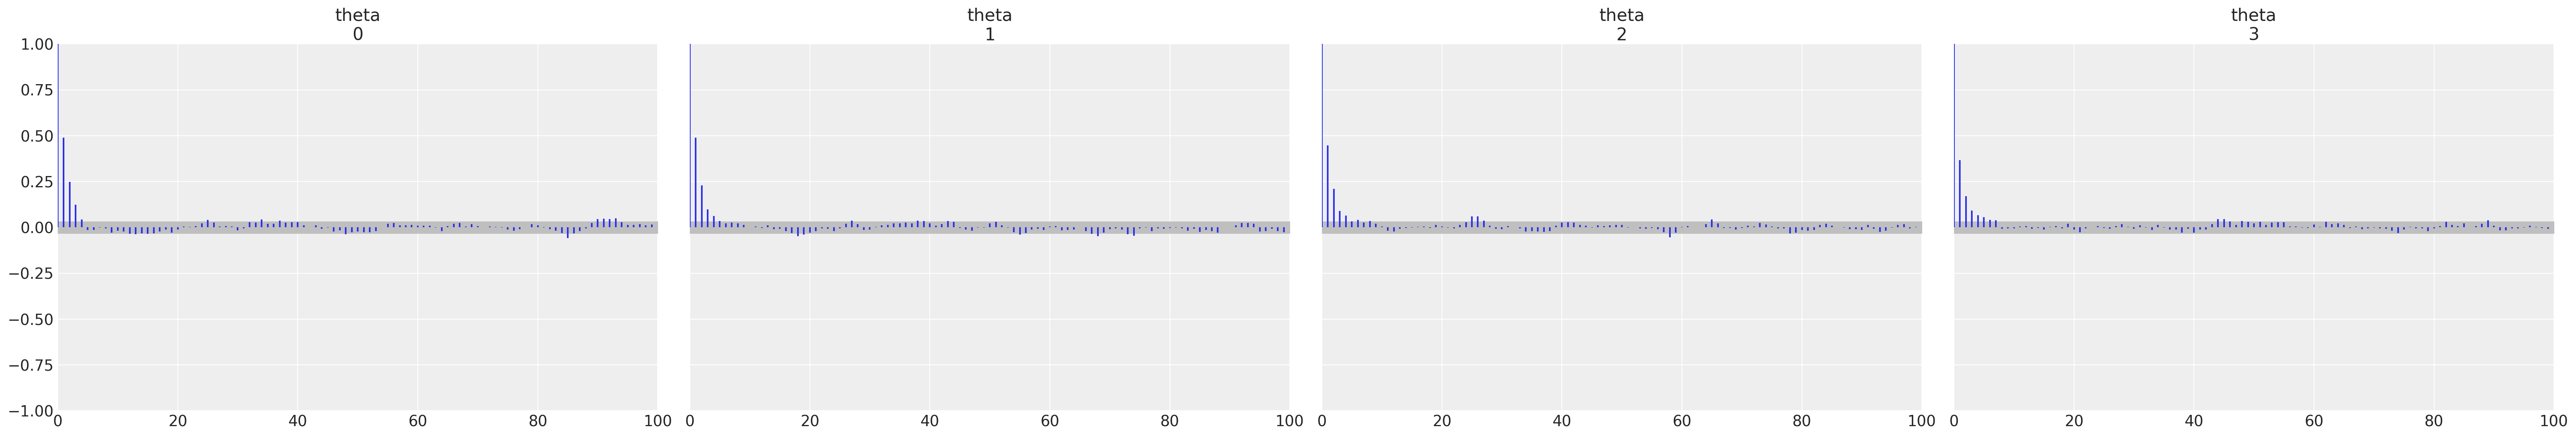

In [21]:
_ = az.plot_autocorr(fit, var_names=("theta"))

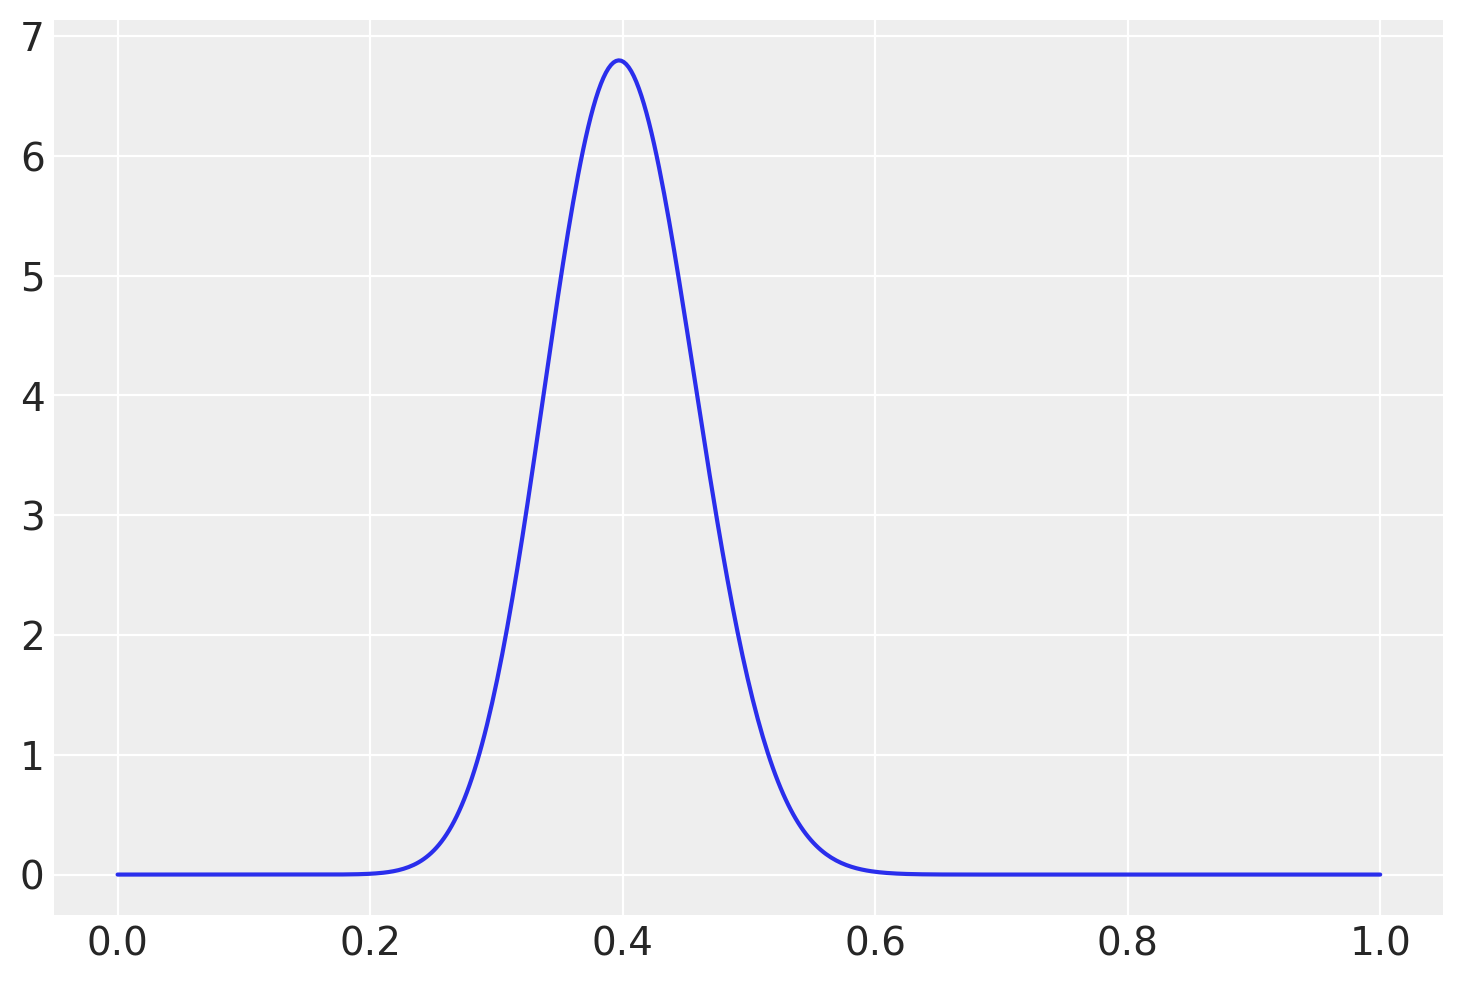

In [22]:
x = np.linspace(0, 1, 500)
_ = plt.plot(x, stats.beta.pdf(x, 28, 70-28))

In [23]:
data = {
    "ntrials" : 27,
    "y" : 4,
    "alpha_prior" : 28,
    "beta_prior" : 42
}
print(data)

{'ntrials': 27, 'y': 4, 'alpha_prior': 28, 'beta_prior': 42}


In [24]:
fit2 = model.sample(
    data=data,
    iter_sampling = 4000,
    iter_warmup = 2000,
    seed = 84735,
    chains = 4
)

09:47:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:47:04 - cmdstanpy - INFO - CmdStan done processing.


In [25]:
az.summary(fit2, var_names=("theta"), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.33,0.047,0.245,0.419,0.001,0.0,6393.0,8533.0,1.0


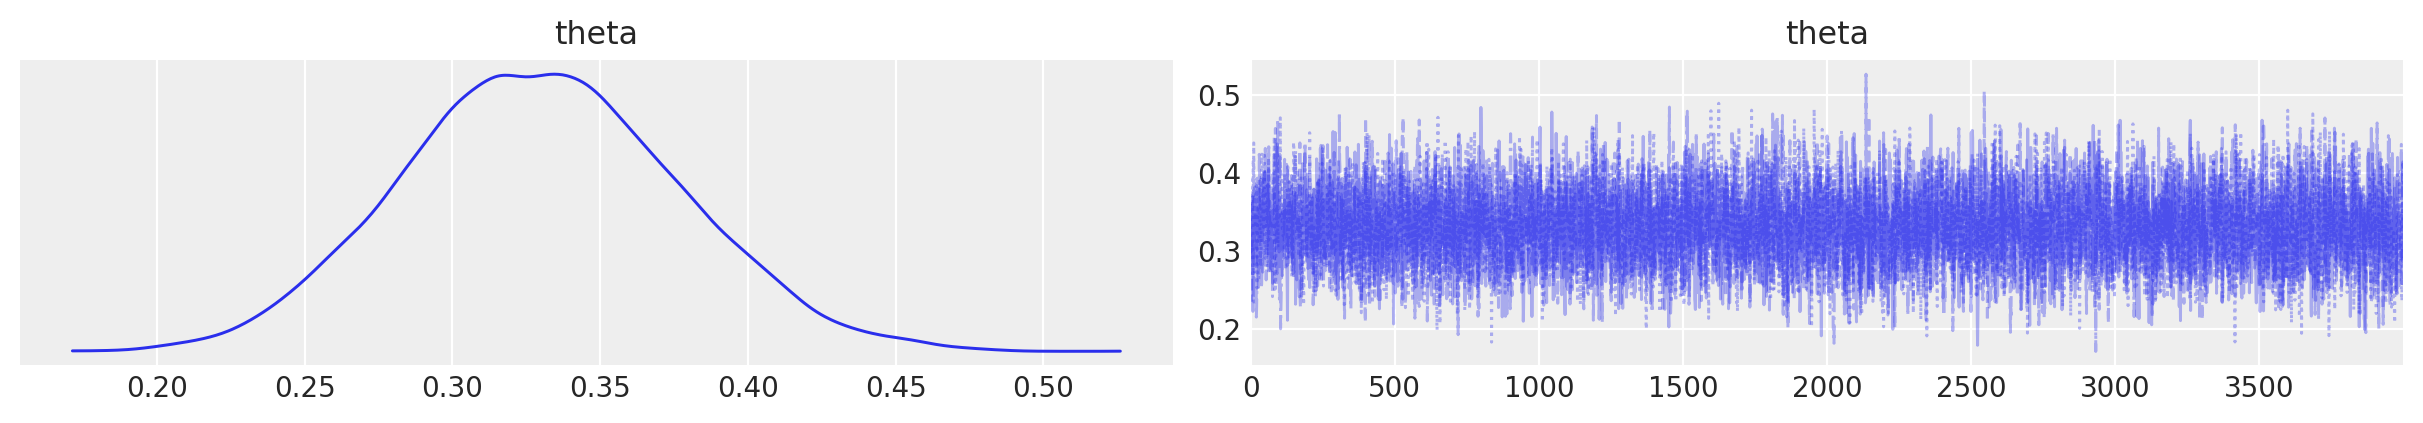

In [26]:
_ = az.plot_trace(fit2, var_names=("theta"), combined=True)

In [27]:
stan_file = os.path.join('stan', 'binomial_model2.stan')
print(stan_file)

stan/binomial_model2.stan


In [28]:
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> ntrials; // Numero di prove
  int<lower=0> y; // Successi osservati
  real<lower=0> alpha_prior; // Parametro alpha per il prior Beta
  real<lower=0> beta_prior; // Parametro beta per il prior Beta
}
parameters {
  real<lower=0, upper=1> theta; // Parametro stimato, limitato tra 0 e 1
}
model {
  // Prior
  theta ~ beta(alpha_prior, beta_prior);
  
  // Likelihood
  y ~ binomial(ntrials, theta);
}
generated quantities {
  int<lower=0> y_pred; // Variabile per la distribuzione predittiva a posteriori
  
  // Generazione dei dati predittivi a posteriori
  // Usa il valore di theta stimato per generare un nuovo risultato
  // da una distribuzione binomiale
  y_pred = binomial_rng(ntrials, theta);
}




In [29]:
data = {
    "ntrials" : 27,
    "y" : 4,
    "alpha_prior" : 2,
    "beta_prior" : 2
}
print(data)

{'ntrials': 27, 'y': 4, 'alpha_prior': 2, 'beta_prior': 2}


In [30]:
model2 = CmdStanModel(stan_file=stan_file)
print(model2)

CmdStanModel: name=binomial_model2
	 stan_file=/Users/corradocaudek/_repositories/temp/chapter_4/stan/binomial_model2.stan
	 exe_file=/Users/corradocaudek/_repositories/temp/chapter_4/stan/binomial_model2
	 compiler_options=stanc_options={}, cpp_options={}


In [31]:
fit2 = model2.sample(
    data=data,
    iter_sampling = 4000,
    iter_warmup = 2000,
    seed = 84735,
    chains = 4
)

09:47:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:47:05 - cmdstanpy - INFO - CmdStan done processing.


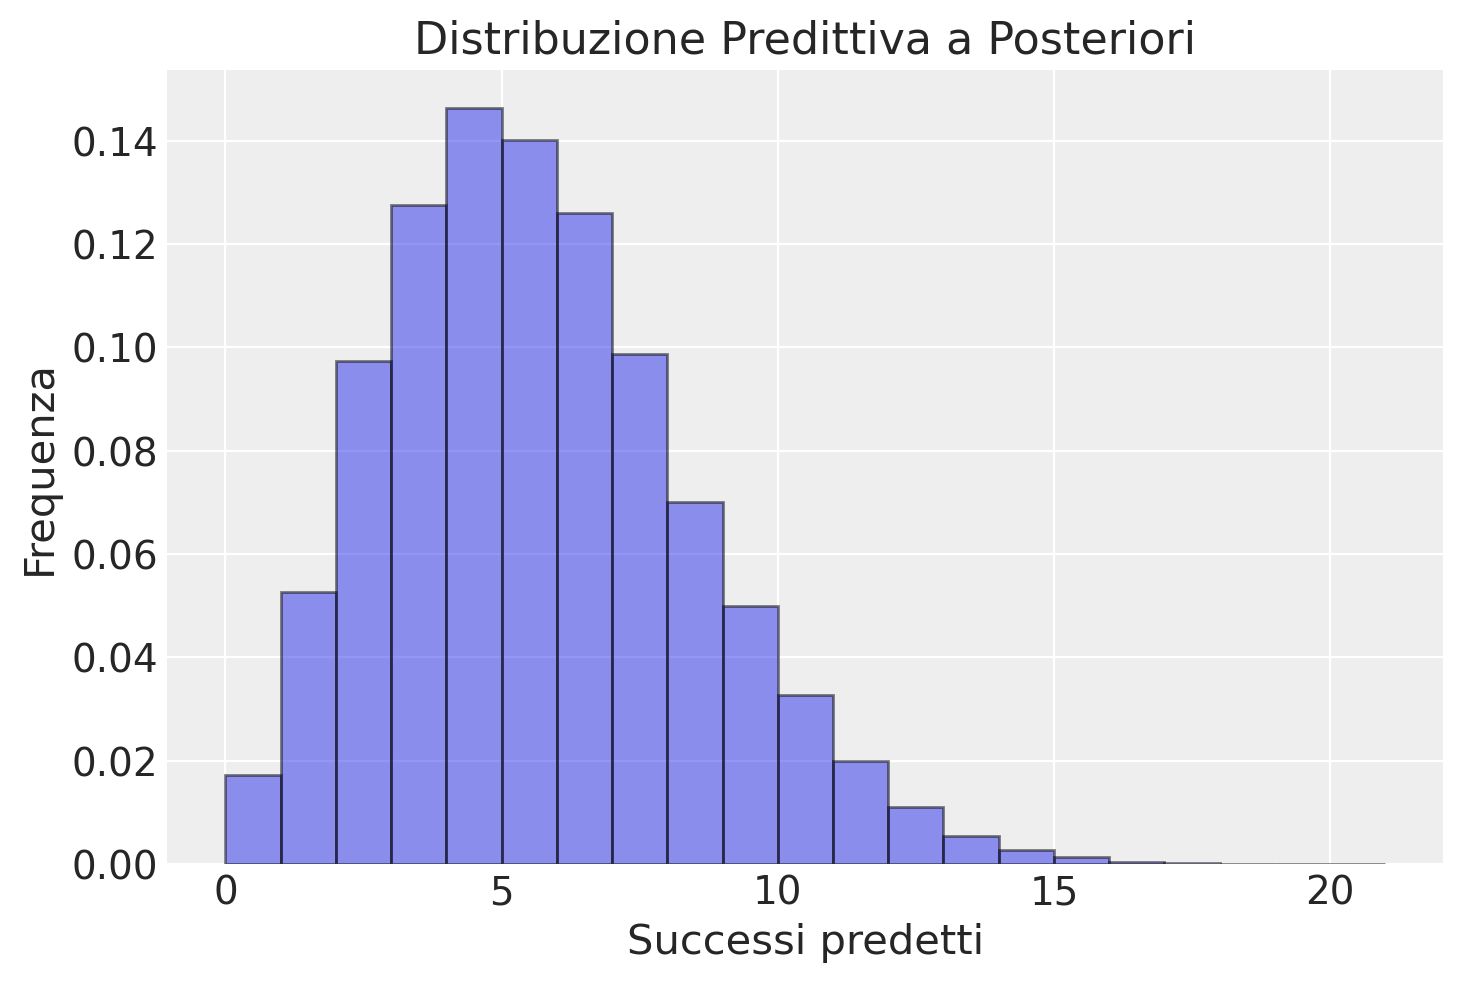

In [32]:
# 'y_pred' è il nome della variabile generata nella sezione `generated quantities` del modello Stan
y_pred = fit2.stan_variable('y_pred')

# Visualizza la distribuzione predittiva a posteriori
plt.hist(y_pred, alpha=0.5, edgecolor='black', density=True, bins=range(0, 22))
plt.title('Distribuzione Predittiva a Posteriori')
plt.xlabel('Successi predetti')
plt.ylabel('Frequenza')
plt.show()

In [33]:
np.mean(y_pred)

5.1923125

In [34]:
stan_file = os.path.join('stan', 'binomial_model3.stan')
print(stan_file)

stan/binomial_model3.stan


In [35]:
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> ntrials; // Numero di prove
  // Si rimuove la variabile 'y' poiché non utilizziamo dati osservati
  real<lower=0> alpha_prior; // Parametro alpha per il prior Beta
  real<lower=0> beta_prior; // Parametro beta per il prior Beta
}
parameters {
  real<lower=0, upper=1> theta; // Parametro stimato, limitato tra 0 e 1
}
model {
  // Prior
  theta ~ beta(alpha_prior, beta_prior);
  
  // Si rimuove la likelihood poiché stiamo generando dati a priori
}
generated quantities {
  int<lower=0> y_pred_prior; // Variabile per la distribuzione predittiva a priori
  
  // Generazione dei dati predittivi a priori
  // Usiamo campioni tratti dai prior per theta per generare un nuovo risultato
  // da una distribuzione binomiale senza considerare 'y'
  y_pred_prior = binomial_rng(ntrials, beta_rng(alpha_prior, beta_prior));
}




In [36]:
model3 = CmdStanModel(stan_file=stan_file)
print(model3)

CmdStanModel: name=binomial_model3
	 stan_file=/Users/corradocaudek/_repositories/temp/chapter_4/stan/binomial_model3.stan
	 exe_file=/Users/corradocaudek/_repositories/temp/chapter_4/stan/binomial_model3
	 compiler_options=stanc_options={}, cpp_options={}


In [37]:
data = {
    "ntrials" : 27,
    "alpha_prior" : 2,
    "beta_prior" : 2
}
print(data)

{'ntrials': 27, 'alpha_prior': 2, 'beta_prior': 2}


In [38]:
fit3 = model3.sample(
    data=data,
    iter_sampling = 4000,
    iter_warmup = 2000,
    seed = 42,
    chains = 4
)

09:47:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:47:06 - cmdstanpy - INFO - CmdStan done processing.


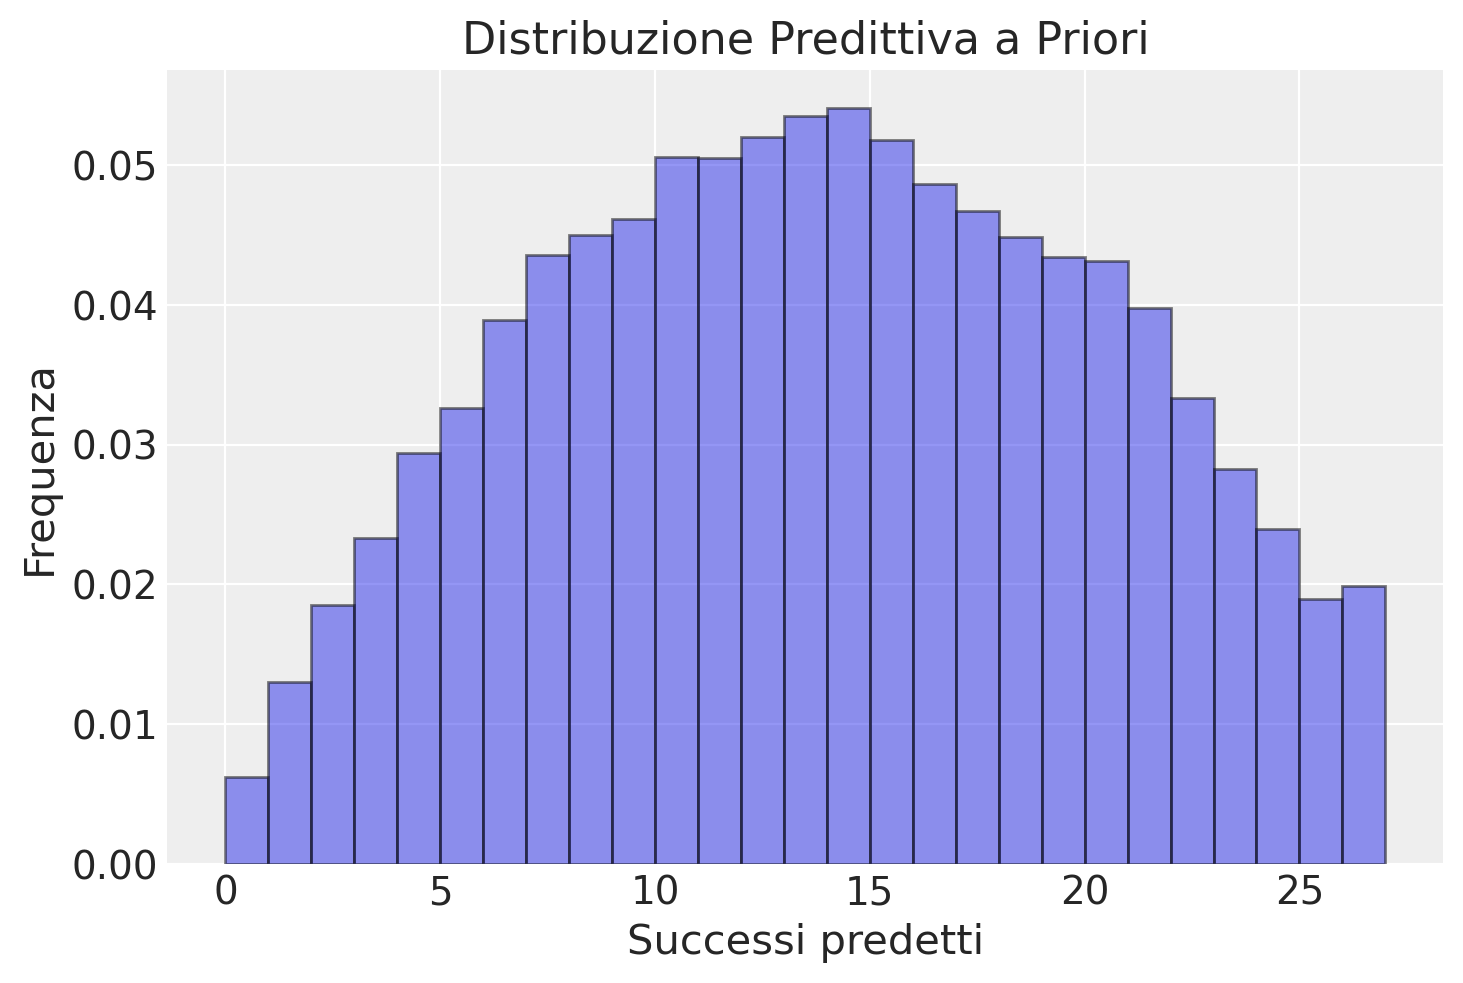

In [39]:
# 'y_pred' è il nome della variabile generata nella sezione `generated quantities` del modello Stan
y_pred_prior = fit3.stan_variable('y_pred_prior')

# Visualizza la distribuzione predittiva a posteriori
plt.hist(y_pred_prior, alpha=0.5, edgecolor='black', density=True, bins=range(0, 28))
plt.title('Distribuzione Predittiva a Priori')
plt.xlabel('Successi predetti')
plt.ylabel('Frequenza')
plt.show()

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

cmdstanpy: 1.2.3

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

arviz     : 0.18.0
scipy     : 1.13.1
matplotlib: 3.8.4
numpy     : 1.26.4

Watermark: 2.4.3

